<a href="https://colab.research.google.com/github/pachterlab/GFCP_2021/blob/main/notebooks/occup_meas_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
t1 = time.time()

# Dependencies and functions


In [2]:
%%capture
!pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git

In [3]:
%%capture
!pip install scanpy
!pip install umap-learn

In [4]:
#For vlm need to save linear/non-linear pca,t-SNE,UMAP,  and true pseudotime/gamma, cluster labels

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import FuncFormatter, MultipleLocator
import numpy as np
import seaborn as sn
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
import umap
import math


import velocyto as vcy
import anndata as ad
import warnings

import scipy
from scipy import integrate
from scipy.fft import irfft, ifft

# parameter
plt.rcParams.update({'font.size': 13})
#girl with the pearl earring - vermeer
vermeer_hex = ("#A65141", "#E7CDC2", "#80A0C7", "#394165", "#FCF9F0", "#B1934A",
             "#DCA258", "#100F14", "#8B9DAF", "#EEDA9D")
vermeer = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in vermeer_hex]
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))

#milkmaid - vermeer
milkmaid_hex = ("#48211A","#376597","#537270","#556246","#928F6B","#CCAF69",
               "#ECE5D3","#104A8A","#C5AC8E","#889F95","#7C4728","#00295D",
               "#D9B196")
milkmaid = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in milkmaid_hex]

#view of delft - vermeer
delft_hex = ("#78A8D1","#D5BF98","#E3C78F","#FDF9F8","#867D6C","#A04437","#AF7366",
         "#EFBF6A","#8E7C56","#CDD4E4","#8B6C4F","#B4B7B9")
delft = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in delft_hex]


emb_dict={"default":'pcs',"PCA":"ps", "UMAP":"us", "tSNE":"ts"}
dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4,"ab(c/d/e)":5}
dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3],"ab(c/d/e)":[2,3,4]}


c0 = vermeer[6] #nascent color
c1 = vermeer[0] #mature color
cbg = vermeer[4] # off-white background to make it stand out

pmfcolor = delft[0] #analytical PMF color
lw_id = 3.4
lw_pmf = 3.4

id_line_color = delft[0]
# id_line_color = milkmaid[1]
region_color = vermeer[2]


def preprocess(vlm, nGene=2000, sim=False, meta=None, filter=True):
    if filter:
        vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))
        vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
        vlm.filter_genes(by_detection_levels=True)
        vlm.score_cv_vs_mean(N=nGene, plot=False, max_expr_avg=35)
        vlm.filter_genes(by_cv_vs_mean=True)

    vlm.normalize("both", size=True, log=True)
    vlm.perform_PCA(which="S_norm")
    vlm.pcs=vlm.pcs[:,:2]
    
    if sim:
        if meta is None:
            raise ValueError("If sim is true, meta cannot be None")
        vlm.colors, vlm.ctime=getClusterTime(vlm.ca["time"],vlm.ca["celltype"], meta)
    else:
        labels = vlm.ca["Clusters"]
        cluster_colors_dict={l:colors20[l % 20,:] for l in labels}
        vlm.colors=[cluster_colors_dict[label] for label in labels]
    return


def makeEmbeds(vlm, embeds, x_name="S_norm", new_pca=True):
    '''
    Save embedding objects in embeds lists in vlm
    
    Parameters
    ----------
    vlm : Velocyto loompy object
    x_name: X for embedding, e.g. "S", "S_norm"
    embeds : set of embeddings e.g. {'PCA','UMAP','tSNE'}
    
    Returns
    -------
    '''
    
    if new_pca or not hasattr(vlm, "PCA"):
        X = getattr(vlm, x_name) # X=(n_samples, n_features)
        vlm.PCA = PCA(n_components=50).fit_transform(X.T)
        
    
    if "PCA" in embeds:
        vlm.ps = np.array(vlm.PCA[:,:2], order="C")
        
    if 'UMAP' in embeds:
        vlm.us = umap.UMAP(n_components=2).fit_transform(vlm.PCA[:, :25])
        
    if 'tSNE' in embeds:
        vlm.ts = TSNE(n_components=2).fit_transform(vlm.PCA[:, :25])

    if "default" in embeds:
        vlm.perform_PCA(which=x_name) # default add attr pca and pcs

    return


def getImputed(vlm, knn_k=50):
    '''
    Get gamma inference from imputed counts
    
    Parameters
    ----------
    
    Returns
    -------
    '''

    vlm.knn_imputation(k=knn_k)
    vlm.normalize("imputed", size=True, log=True)

    #Get gamma inference
    delta_t = 1
    vlm.used_delta_t = delta_t
    vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
        
    vlm.delta_S = vlm.Ux_sz - vlm.gammas[:,None] * vlm.Sx_sz # same as vlm.predict_U() and vlm.calculate_velocity()
    vlm.Sx_sz_t = vlm.Sx_sz + delta_t * vlm.delta_S  # same as vlm.extrapolate_cell_at_t(delta_t=1)

    return


def plotGrid(ax,vlm,gridx,gridv,trans, scale=5, c="gray"):
    '''
    Plot grid with arrows given embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    x=getattr(vlm, gridx)
    v=getattr(vlm, gridv)
    masks=vlm.total_p_mass>0.1
    ax.quiver(x[masks, 0], x[masks, 1], v[masks, 0], v[masks, 1], linewidth=6.5, scale=scale, label=trans, color=c)
    return

def linear_embed(vlm):
    '''
    Linear embed the velocity
    
    Parameters
    ----------
    
    Returns
    -------
    v: velocity arrows for each cell
    '''
    delta_S_sz = vlm.U_sz - vlm.gammas[:,None] * vlm.S_sz # same as vlm.predict_U() and vlm.calculate_velocity()
    mask=delta_S_sz<-1e-6
    delta_t=np.min(vlm.S_sz[mask]/np.abs(delta_S_sz[mask]))
    vlm.S_sz_t = vlm.S_sz + delta_t/2 * delta_S_sz  # same as vlm.extrapolate_cell_at_t(delta_t=1)
    v=vlm.pca.transform(np.log2(vlm.S_sz_t.T+1))[:,:2]-vlm.pcs[:,:2]
    return v

def SimArrowPlots(vlm,meta=None,ax=None,quiver_scale=5):
    if ax==None:
        fig, ax = plt.subplots(2,2,figsize=(12,8))
        
    plotEmbed(ax,vlm,emb)
        
    


def gridArrowPlots(vlm,Trans,embed,sim=False,meta=None,ax=None,legend=True,quiver_scale=5,title=True):
    '''
    Plot arrow embeddings for vlm data with defined count transformations
    
    Parameters
    ----------
    sim: boolean to look for true pseudotime or cluster and/or principal curve
    
    Returns
    -------
    
    '''
    if not hasattr(vlm,"delta_S"):
        getImputed(vlm, knn_k=50)
    makeEmbeds(vlm, embeds=embed, x_name='S_norm', new_pca=False)
    emb=emb_dict[embed]
    if ax is None:
        fig,ax=plt.subplots(1,1)
        
    plotEmbed(ax,vlm,emb,sim=sim)
    
    for i,trans in enumerate(Trans):
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans,
                                n_neighbors=150, knn_random=False, sampled_fraction=1)

        if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
            warnings.warn("Nan values in corrcoef, setting them to 0")
            vlm.corrcoef[np.isnan(vlm.corrcoef)]=0

        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        vlm.calculate_grid_arrows(smooth=0.5, steps=(10, 10), n_neighbors=100)

        plotGrid(ax,vlm,"flow_grid","flow", trans, scale=quiver_scale, c=vermeer[(7+i) % 10])
    
    # plot baseline arrows or curves
    if embed=="PCA":
        if sim:
            princCurvePlots(ax,vlm,meta,color=False)
        else:
            v=linear_embed(vlm)
            ax.quiver(vlm.pcs[:,0], vlm.pcs[:,1], v[:, 0], v[:, 1], alpha=0.8, linewidth=3, scale=5, label="baseline")
   
    if legend:
        ax.legend(loc='upper right') #bbox_to_anchor=(1.05, 1.0), 
    if title:
        ax.set_title(embed)
        
    ax.axis('off')
    
    if ax is None:
        return fig
    else:
        return ax



    
# ---------------- Simulation -------------

def eval_x_interval(k_,dt,beta,gamma,x0):
    '''
    Evaluates a single gene's average expression at a time point dt after
    the system is started. This solution results from the reaction
    rate equations, and is specifically implemented for a time interval wherein
    the parameter values are constant.
    
    Parameters
    ----------
    k_: transcription rate (constitutive)
    dt: time since system is started
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0
    
    Returns
    -------
    x: average expression value (vector, unspliced and spliced)
    '''
    gamma /= beta
    dt *= beta
    k_ /= beta
    x = np.array([k_*(1-np.exp(-dt)) + x0[0]*np.exp(-dt),
        np.exp(-dt*gamma) * \
        (np.exp(dt*gamma) * k_ * (gamma-1) + \
        - k_*np.exp(dt*(gamma-1))*gamma \
        + k_\
        + (gamma-1)*gamma*x0[1] \
        +gamma*x0[0]*(np.exp((gamma-1)*dt)-1)) \
        /gamma/(gamma-1)])
    return x

def eval_x(k,tau,t,beta,gamma,x0=None):
    '''
    Evaluates a single gene's average expression at a time point t.
    This solution derives from the reaction rate equations. The value is
    computed by evaluating the RREs piecewise over succeeding intervals
    until time t is reached.
    
    Parameters
    ----------
    k: transcription rate (constitutive, given by a vector over "cell types")
    tau: cell type transition times
    t: time of interest
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0 (in this case, we assume it starts with Poisson)
    
    Returns
    -------
    x: average expression value (vector, unspliced and spliced)
    '''
    # x=x0
    if x0 is None:
        x0 = [k[0]/beta, k[0]/gamma]
    x=x0
    ind_last = sum(tau<=t)
    tau = np.concatenate((tau[:(ind_last)],[t]))
    for ind in range(ind_last):
        x = eval_x_interval(k[ind],tau[ind+1]-tau[ind],beta,gamma,x)
    return x

def poiss_samp(k,tau,t,beta,gamma):
    '''
    Simulates a single gene's expression at a time point t.
    This solution derives from the reaction rate equations. The average
    expression is computed; then, a Poisson random variable with that
    expectation is sampled to produce an observation.
    
    Parameters
    ----------
    k: transcription rate (constitutive, given by a vector over "cell types")
    tau: cell type transition times
    t: time of interest
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0
    
    Returns
    -------
    x: instantaneous expression (vector, unspliced and spliced)
    '''
    x = np.random.poisson(eval_x(k,tau,t,beta,gamma))
    return x

def get_cell_spec_K(K,cell_type):
    k = [K[0],K[1],K[cell_type]]
    return np.array(k)

def simulate_occup_meas(nCells=2000, nGenes=100, T=20, tau = [0,8,13], topo="ab(c/d/e)", seed=42):
    '''
    Simulates a gene expression given a constitutive model with transient
    dynamics. A vector of observation times is initializated; then, the
    occupation measures are sampled to produce single-molecule observations
    consistent with canonical RNA velocity models.
    
    Parameters
    ----------
    nCells: number of cells to simulate
    nGenes: number of genes to simulate
    T: process halting time
    tau: process-wide transition times
    topo: string indicating whether the process topology. This defines the
    transcription rate arrays K over the trajectory.
        "aba": cells are perturbed and return back to the original attractor.
            2 parameters.
        "ab(a/c)": cells are perturbed; half return and half seek a new attractor.
            3 parameters (one is duplicated).
        "ab(c/d)" cells branch to attractors c and d through b.
            4 parameters.

    Returns
    -------
    X: spliced and unspliced samples from occupation measure
        (array, 2 x nCells x nGenes)
    branch_cells: indices of cells that branch off
    tvec: ground truth pseudotimes
    K: ground truth initiation rates
    g_true: ground truth degradation rates
    b_true: ground truth splicing rates (all 1)
    '''
    #define occupation measure for sampling: df = dt/T
    np.random.seed(seed)
    tvec = np.random.rand(nCells)*T
    #initialize arrays for simulations
    X = np.zeros((2,nCells,nGenes))
    g_true = np.zeros(nGenes)
    b_true = np.zeros(nGenes)
    cell_types = np.zeros(nCells,dtype=int)

    cell_types[tvec<tau[1]] = 0 #a
    cell_types[(tvec>tau[1]) & (tvec<tau[2])] = 1
    if topo == "aba":
        n_K = 2
        cell_types[tvec>tau[2]] = 0
        # print("aba")
    elif topo == "ab(c/d/e)":
        # three fates topo
        n_K = 5
        cell_fate=np.random.randint(3,size=nCells)
        cell_types[(tvec>tau[2]) & (cell_fate==0)] = 2
        cell_types[(tvec>tau[2]) & (cell_fate==1)] = 3
        cell_types[(tvec>tau[2]) & (cell_fate==2)] = 4
        print("ab(c/d/e)")
    else:
        n_branch_cells = int(nCells/2)
        branch_cells = np.random.choice(nCells,n_branch_cells,False)
        filt = np.zeros(nCells,dtype=bool)
        filt[branch_cells] = True
        if topo == "ab(a/c)":
            n_K = 3
            cell_types[(tvec>tau[2]) & ~filt] = 0
            cell_types[(tvec>tau[2]) & filt] = 2
            print("ab(a/c)")
        if topo == "ab(c/d)":
            n_K = 4
            cell_types[(tvec>tau[2]) & ~filt] = 2
            cell_types[(tvec>tau[2]) & filt] = 3
            print("ab(c/d)")
   
    K = np.zeros((nGenes,n_K))


    for j in range(nGenes):
        # print(j)
        FLAG = True
        while FLAG:
            #this defines states a, b, c, d.
            kinit = 10**np.random.normal(0,size=n_K)
            K[j,:] = kinit
            # print(kinit)
            beta = 10**np.random.normal(1,0.5)
            b_true[j]=beta
            gamma = 10**np.random.normal(0.5,0.25)
            # gamma = 10**np.random.normal(0,0.5)
            g_true[j] = gamma

            try: #the simulation procedure is not necessarily stable. If it
                #produces unreasonable samples, we resample the parameters.
                for i in range(nCells):
                    # print(nCells)
                    # x0 = [kinit[0]/beta, kinit[0]/gamma]
                    X[:,i,j]= poiss_samp(get_cell_spec_K(K[j],cell_types[i]),tau,tvec[i],beta,gamma)
                    # print(i)
                    # if i==0:
                    #     print(K[j,cell_types[i]])
                    #     print(tvec[i])
            except:
                # print(kinit)
                # print(x0)
                # print('big yikes')
                # poiss_samp(get_cell_spec_K(K[j],cell_types[i]),tau,tvec[i],beta,gamma)
                pass
            
            if ~np.any(np.isnan(X[:,:,j])):
                FLAG=False
    return X,cell_types,tvec,K,g_true,b_true

def sim_export(simdata, meta, name="simdata"):
    X,cell_types,tvec,K,g_true,b_true = simdata
    nCells,nGenes,T,tau,topo = meta
    adata=ad.AnnData(np.sum(X,axis=0))
    adata.layers["spliced"] = X[1,:,:]
    adata.layers["unspliced"] = X[0,:,:]
    adata.layers["ambiguous"]=np.zeros_like(X[1,:,:])
    # br = np.zeros(nCells,dtype=bool)
    # br[branch_cells]=True
    adata.obs["time"]=tvec
    adata.obs["celltype"]=cell_types
    adata.var["gamma"]=g_true
    adata.var["beta"]=b_true
    adata.var["Gene"]=np.asarray([str(i) for i in range(len(g_true))])
    # adata.uns["K"]=K
    n_K = K.shape[1]
    for i in range(n_K):
        adata.var["k"+str(i)]=K[:,i]
    # adata.var["km"]=K[:,1]
    # adata.var["k1"]=K[:,2]
    # adata.var["k2"]=K[:,3]
    # adata.uns['tau']=tau
    adata.write_loom(name+".loom")


# def simPdfPlot(ax,vlm):
#     pmf_nas = get_nas(K,tau,T,beta,np.max(Xg[0]))
#     pmf_mat = get_mat(K,tau,T,beta,gamma,np.max(Xg[1]))
def simValidPlots(vlm,tau,meta,geneind=0,knn_k=50):
    '''
    Plot sim validation figures.
    These should be later combined into a single figure, instead of several.
    MAKE SURE THE IMPUTATION HAPPENS.
    '''
    # nCells,nGenes,T,tau,topo = meta
    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.005))[0][0]
    vlm.knn_imputation(n_pca_dims=n_comps,k=knn_k, balanced=True, b_sight=np.minimum(knn_k*8, vlm.S.shape[1]-1), b_maxl=np.minimum(knn_k*4, vlm.S.shape[1]-1))

    fig=plt.figure(figsize=(20,15))

    Xtheo = getGroundTruthAvg(vlm,tau)

    ax1=[]
    for i in range(4):
        ax1.append(plt.subplot2grid((14, 12), (7, i*3), rowspan=3, colspan=3))
    selection_names = ['U','S']

    for i in range(2):
        plotImpMeanPerformance(ax1[i],vlm,Xtheo,selection_names[i])
        plotImpVarPerformance(ax1[2+i],vlm,Xtheo,selection_names[i])
    ax1[0].set_xlabel(r'True $\mu_u$')
    ax1[0].set_ylabel('Pooled unspliced mean')
    ax1[1].set_xlabel(r'True $\mu_s$')
    ax1[1].set_ylabel('Pooled spliced mean')
    ax1[2].set_xlabel(r'True $\sigma^2_u$')
    ax1[2].set_ylabel('Pooled unspliced var')
    ax1[3].set_xlabel(r'True $\sigma^2_s$')
    ax1[3].set_ylabel('Pooled spliced var')
    ax1[0].text(0.04,0.96,r'Identity $\pm$ 1 OOM',transform=ax1[0].transAxes,fontsize=20,horizontalalignment='left',verticalalignment='top',color=id_line_color)

    ax2=[]
    for i in range(3):
        ax2.append(plt.subplot2grid((14, 12), (3, i*4), rowspan=4, colspan=4))
    selection_names = ['raw','size_norm','imputed']
    for i in range(3):
        plotSimCounts(ax2[i],vlm,geneind,selection_names[i])
        plotGroundTruthCounts(ax2[i],vlm,geneind,tau)
    ax2[0].set_ylabel('Abundance')
    ax2[0].set_title('Raw counts')
    ax2[1].set_title('Size-normalized counts')
    ax2[2].set_title('Imputed counts')
    ax2[0].text(0.04,0.5,'Spliced',horizontalalignment='left',color=c1,verticalalignment='top',fontsize=20,transform=ax2[0].transAxes)
    ax2[0].text(0.04,0.4,'Unspliced',horizontalalignment='left',color=c0,verticalalignment='top',fontsize=20,transform=ax2[0].transAxes)

    ax3=[]
    for i in range(3):
        ax3.append(plt.subplot2grid((14, 12), (10, i*4), rowspan=4, colspan=4))

    # ax3[0].set_ylabel("Imputed gamma")
    # ax3[1].set_ylabel("True gamma")
    vlm.fit_gammas(use_imputed_data=False, use_size_norm=False, weighted=False)
    plotGamma(ax3[0],vlm)
    vlm.fit_gammas(use_imputed_data=False, use_size_norm=True, weighted=True, weights="maxmin_diag")
    plotGamma(ax3[1],vlm)
    vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
    plotGamma(ax3[2],vlm)
    ax3[0].set_ylabel(r'$\gamma$ inferred from raw')
    ax3[1].set_ylabel(r'$\gamma$ inferred from size-normalized')
    ax3[2].set_ylabel(r'$\gamma$ inferred from imputed')
    # ax3[0].set_title('Inference from raw counts')
    # ax3[1].set_title('Inference from size-normalized counts')
    # ax3[2].set_title('Inference from imputed counts')

    ax4=[]
    for i in range(3):
        ax4.append(plt.subplot2grid((14, 12), (0, i*4), rowspan=3, colspan=4))
    mx = plotHist(ax4[1],vlm,'U',geneind)
    pmf = getPMF(vlm,mx,'U',geneind,meta)
    plotPMF(ax4[1],pmf)
    ax4[1].set_ylabel('Probability')
    ax4[1].text(2,pmf[0],'Analytical solution',color=pmfcolor,horizontalalignment='left',verticalalignment='top',fontsize=20)
    ax4[1].set_xlabel('# unspliced RNA')

    mx = plotHist(ax4[2],vlm,'S',geneind)
    pmf = getPMF(vlm,mx,'S',geneind,meta)
    plotPMF(ax4[2],pmf)
    ax4[2].set_xlabel('# spliced RNA')

    plotK(ax4[0],vlm,geneind,meta)
    return fig

def plotPMF(ax,pmf):
    x = np.arange(0,len(pmf))
    ax.plot(x,pmf,color=pmfcolor,linewidth=lw_pmf)
    ax.set_yscale('log')
    ax.set_xticks(x)

def plotHist(ax,vlm,species_str,geneind):
    X = getattr(vlm,species_str)[geneind,:]
    bins = np.arange(0,np.max(X)+1,1)-0.5
    ax.hist(X,density=True,bins=bins,facecolor=[0.8]*3) 
    return np.max(X)+1

def get_nas(k,tau,T,beta,lm):
    lm = int(lm)
    mx = lm//2 + 1
    l = np.arange(mx)
    u_ = np.exp(-2j*np.pi*l/lm)-1
    fun = lambda t: np.exp(u_*eval_x(k,tau,t,beta,1,[0,0])[0])
    gf = scipy.integrate.quad_vec(fun,0,T)[0]/T
    Pss = irfft(gf,lm) 
    return Pss

def get_mat(k,tau,T,beta,gamma,lm):
    lm = int(lm)
    mx = lm//2 + 1
    l = np.arange(mx)
    u_ = np.exp(-2j*np.pi*l/lm)-1
    fun = lambda t: np.exp(u_*eval_x(k,tau,t,beta,gamma,[0,0])[1])
    gf = scipy.integrate.quad_vec(fun,0,T)[0]/T
    Pss = irfft(gf,lm) 
    return Pss

def getPMF(vlm,mx,species_str,geneind,meta):
    nCells,nGenes,T,tau,topo=meta
    tau = np.asarray(tau)
    # tvec = vlm.ca['time']
    gamma = vlm.ra['gamma'][geneind]
    beta = vlm.ra['beta'][geneind]
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
    branches = dict_Kval[topo]
    n_branches = len(branches)
    K = get_cell_spec_K(K[geneind],branches[0])

    if species_str is 'U':
        return get_nas(K,tau,T,beta,mx)
    elif species_str is 'S':
        return get_mat(K,tau,T,beta,gamma,mx)

def plotImpMeanPerformance(ax,vlm,Xtheo,selection):
    if selection is 'U':
        field_str = 'Ux'
        i = 0
    elif selection is 'S':
        field_str = 'Sx'
        i = 1
    ground_truth = Xtheo[i].T.flatten()
    imputed_value = getattr(vlm,field_str).flatten()
    xl = np.linspace(min(ground_truth),max(ground_truth))
    ax.scatter(ground_truth,imputed_value,color='k',s=5,alpha=0.4)
    ax.fill_between(xl,xl/10,xl*10,facecolor=region_color,alpha=0.3)
    ax.plot(xl,xl,'-',linewidth=lw_id,color=id_line_color)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlabel(selection + ' ground truth mean')
    # ax.set_ylabel(selection + ' imputed mean')
    
def plotImpVarPerformance(ax,vlm,Xtheo,selection):
    if selection is 'U':
        field_str = 'Ux_var'
        i = 0
    elif selection is 'S':
        field_str = 'Sx_var'
        i = 1
    ground_truth = Xtheo[i].T.flatten()
    imputed_value = getattr(vlm,field_str).flatten()
    xl = np.linspace(min(ground_truth),max(ground_truth))
    ax.scatter(ground_truth,imputed_value,color='k',s=5,alpha=0.4)
    ax.fill_between(xl,xl/10,xl*10,facecolor=region_color,alpha=0.3)
    ax.plot(xl,xl,'-',linewidth=lw_id,color=id_line_color)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.loglog(ground_truth,imputed_value,'k.')
    # ax.plot(xl,xl,'r-',linewidth=2)
    # ax.plot(xl,xl*10,'b-')
    # ax.plot(xl,xl/10,'b-')
    # ax.set_xlabel(selection + ' ground truth var')
    # ax.set_ylabel(selection + ' imputed var')



def getGroundTruthAvg(vlm,tau):
    i=0  #just recycling the more generic code
    tvec = vlm.ca['time']
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
    
    branches = dict_Kval[topo]
    n_branches = len(branches)

    i=0
    Xtheo = [[eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec] for j in range(nGenes)]
    Xtheo = np.asarray(Xtheo)
    Xtheo[np.isnan(Xtheo)]=0
    Xtheo[np.isinf(Xtheo)]=0
    Xtheo = np.swapaxes(Xtheo,0,2)
    return Xtheo

def plotGamma(ax,vlm):
    x = vlm.ra['gamma']/vlm.ra['beta']
    tmp = vlm.gammas
    vlm.gammas[vlm.gammas<1e-4]=1e-4
    # ax.loglog(x,vlm.gammas,'k.')
    xl = np.linspace(min(x),max(x))
    ax.scatter(x,vlm.gammas,c='k',s=10,alpha=0.9)
    ax.fill_between(xl,xl/10,xl*10,facecolor=region_color,alpha=0.3)
    ax.plot(xl,xl,'-',linewidth=lw_id,color=id_line_color)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'True $\gamma$')
    # ax.plot(xl,xl,'r-',linewidth=2)
    # ax.plot(xl,xl*10,'b-')
    # ax.plot(xl,xl/10,'b-')
    vlm.gammas = tmp

def plotSimCounts(ax,vlm,geneind,selection):
    if selection is 'raw':
        U_str = 'U'
        S_str = 'S'
    elif selection is 'size_norm':
        U_str = 'U_sz'
        S_str = 'S_sz'
    elif selection is 'imputed':
        U_str = 'Ux'
        S_str = 'Sx'
    U = getattr(vlm,U_str)[geneind,:]
    S = getattr(vlm,S_str)[geneind,:]
    tvec = vlm.ca['time']

    siz=2
    alf=0.5
    ax.scatter(tvec,U,color=c0,s=siz,alpha=alf)
    ax.scatter(tvec,S,color=c1,s=siz,alpha=alf)

def plotGroundTruthCounts(ax,vlm,geneind,tau):
    #there are better ways to do this

    j=geneind
    tvec = vlm.ca['time']
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
    
    branches = dict_Kval[topo]
    n_branches = len(branches)

    i=0
    Xtheo = [eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec]
    Xtheo = np.asarray(Xtheo)
    Xtheo[np.isnan(Xtheo)]=0
    Xtheo[np.isinf(Xtheo)]=0

    I_ = np.argsort(tvec)
    tvec = tvec[I_]
    Xtheo = Xtheo[I_]
    # ax.plot(tvec,Xtheo,linewidth=2)
    siz=2
    ax.plot(tvec,Xtheo[:,0],color=cbg,linewidth=6)
    ax.plot(tvec,Xtheo[:,0],color=c0,linewidth=2)
    ax.plot(tvec,Xtheo[:,1],color=cbg,linewidth=6)
    ax.plot(tvec,Xtheo[:,1],color=c1,linewidth=2)
    ax.set_xlabel('Time coordinate')
    # x0 = [K[geneind,0],K[geneind,0]/g_true[geneind]]
    # plt.plot(tvec,[eval_x(K[geneind,:],tau,t,1,g_true[geneind],x0)[0] for t in tvec],'k.')
    # plt.plot(tvec,[eval_x(K[geneind,:],tau,t,1,g_true[geneind],x0)[1] for t in tvec],'r.')


def getClusterTime(tvec,labels,meta,alpha=1):
    nCells,nGenes,T,ori_tau,topo = meta
    tau=ori_tau.copy()
    tau.append(T)
    ctime=tvec.copy()
    for i in range(len(tau)-1):
        ctime[(tvec>=tau[i]) & (tvec<tau[i+1])]=(ctime[(tvec>=tau[i]) & (tvec<tau[i+1])]-tau[i])/(tau[i+1]-tau[i])
    cluster_colors_dict={l:colors20[l % 20,:] for l in labels}
    colors=np.array([cluster_colors_dict[label] for label in labels])
    #colors[:,0]=colors[:,0]*((1-alpha)+alpha*(1-ctime))
    return colors, ctime


def plotEmbed(ax,vlm,embed,sim):
    '''
    Plot given embedding (UMAP, t-SNE, etc)
    
    Parameters
    ----------
    c: colors

    Returns
    -------
    '''
    x=getattr(vlm, embed)
    if sim:
        ax.scatter(x[:,0],x[:,1],marker=".", s=10+100*vlm.ctime, c=vlm.colors, alpha=0.8, edgecolors="none")
    else:
        ax.scatter(x[:,0],x[:,1],marker=".", c=vlm.colors, alpha=0.8, edgecolors="none")
    return



    
def plotPhase(ax, vlm, gene_idx, jitter=False):
    '''
    Plot phase portrait
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    y=vlm.Ux[gene_idx,:]
    x=vlm.Sx[gene_idx,:]
    k=vlm.gammas[gene_idx]
    b=vlm.q[gene_idx]
    
    x_=np.array([np.amin(x), np.amax(x)])
    ax.plot(x_, x_*k+b+np.random.normal(0,0.1,size=x_.shape), color=vermeer[0], linewidth=4)
    
    if jitter:
        ax.scatter(x+np.random.normal(0,0.1,size=x.shape), y+np.random.normal(0,0.1,size=x.shape), c=vlm.colors, s=1)
    else:
        ax.scatter(x, y, c=vlm.colors, s=1)
    return


def plotGammaK(ax, vlm, gene_idx, n_neigh, gamma, q, sim=False):
    '''
    Plot gamma over k neighbors for gene at gene_idx
    
    Parameters
    ----------
    
    Returns
    -------
    
    '''
    ax.plot(n_neigh, gamma, color=vermeer[0],label="gamma",lw=6)
    if sim:
        ax.plot(n_neigh,vlm.ra["gamma"][gene_idx]/vlm.ra["beta"][gene_idx]*np.ones(len(n_neigh)),'r-',label="true gamma")
    ax.set_ylabel("gamma")
    ax.yaxis.label.set_color(vermeer[0])
    frac=vlm.Ux[gene_idx,:,None] - vlm.Sx[gene_idx,:,None]*gamma[None,:] - q[None,:]
    frac=np.sum(frac>0,axis=0)/np.shape(frac)[0]
    ax2=ax.twinx()
    ax2.plot(n_neigh, frac, color=vermeer[3],label="frac",lw=6)
    ax2.set_ylabel("perc cells unregulated")
    ax2.yaxis.label.set_color(vermeer[3])
    ax2.set_ylim([0,1])
    return

def phasePlots(vlm, genes, n_neighs, n_neighs_list, sim=False, zero_is_special=True):
    '''
    Plot phase portrais with gamma distributions for various genes across n_neighs
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    if type(genes) is list or type(genes) is tuple: #looking at SPECIFIC genes enumerated in an iterable
        m = len(genes)
    else: #just some random genes
        m = genes
        genes = np.random.choice(vlm.ra['Gene'],m,replace=False)
    
    
    n = len(n_neighs)
    n2 = len(n_neighs_list)
    gammas = np.zeros((m,n2))
    q = np.zeros((m,n2))
    
    fig, ax = plt.subplots(m,n+1,figsize=((n+1)*6,m*4))
    
    # generate phase plots
    for j, knn_k in enumerate(n_neighs):
        if knn_k>0:
            vlm.knn_imputation(k=knn_k)
            vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
            
            # Plot phase plots
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                plotPhase(ax[i][j], vlm, gene_idx)
   
        elif zero_is_special:
            vlm.Sx=vlm.S
            vlm.Ux=vlm.U
            vlm.gammas=np.zeros(len(vlm.S))
            vlm.q=np.zeros(len(vlm.S))
            ## vlm fit_gammas is not working!!! use sklearn linear regression instead
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                reg = LinearRegression().fit(vlm.S[gene_idx,:].reshape(-1,1), vlm.U[gene_idx,:].reshape(-1,1))
                vlm.gammas[gene_idx]=reg.coef_
                vlm.q[gene_idx]=reg.intercept_
                
            # Plot phase plots
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                plotPhase(ax[i][j], vlm, gene_idx, jitter=True)
        else:
            vlm.Sx=vlm.S
            vlm.Ux=vlm.U
            vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
             
            # Plot phase plots
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                plotPhase(ax[i][j], vlm, gene_idx, jitter=True)

    for j, k in enumerate(n_neighs_list):
        knn_k=int(k)
        if knn_k>0:
            vlm.knn_imputation(k=knn_k)
            vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                gammas[i,j]=vlm.gammas[gene_idx]
                q[i,j]=vlm.q[gene_idx]
        else:
            vlm.Sx=vlm.S
            vlm.Ux=vlm.U
            ## vlm fit_gammas is not working!!! use sklearn linear regression instead
            for i, gene in enumerate(genes):
                gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
                reg = LinearRegression().fit(vlm.S[gene_idx,:].reshape(-1,1), vlm.U[gene_idx,:].reshape(-1,1))
                gammas[i,j]=reg.coef_
                q[i,j]=reg.intercept_
            
    for i, gene in enumerate(genes):
        gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
        plotGammaK(ax[i][n], vlm, gene_idx, n_neighs_list, gammas[i,:], q[i,:], sim=sim)
    ax[m-1][n].set_xlabel("k neighbors")
    
    for i in range(m-1):
        for j in range(n):
            ax[i][j].axes.xaxis.set_ticklabels([])
        
    for i in range(m):
        for j in range(1,n):
            ax[i][j].axes.yaxis.set_ticklabels([])      
            
    for i in range(m):
        ax[i,0].set_ylabel("unspliced")
    for j in range(n):
        ax[m-1,j].set_xlabel("spliced")

    fig.tight_layout(pad=0.4, w_pad=0.4, h_pad=0.4)
    
    return fig



def getNeighbors(embed, n_neigh = 150, p=1):
    """Get indices of nearest neighbors in embedding (shape n_samples,n_features)"""
    nbrs = NearestNeighbors(n_neighbors=n_neigh, p=p).fit(embed)
    distances, indices = nbrs.kneighbors(embed)
    return indices

def getJaccard(x1, x2, n_neigh=150):
    '''
    Get jaccard distance between embeddings
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    embed1_neighbor = getNeighbors(x1,n_neigh)
    embed2_neighbor = getNeighbors(x2,n_neigh)
    frac = [0]*embed1_neighbor.shape[0]
    for i in range(embed1_neighbor.shape[0]):
        inter = set(embed1_neighbor[i,:]).intersection(embed2_neighbor[i,:])
        frac[i] = 1-len(inter)/len(set(embed1_neighbor[i,:]).union(embed2_neighbor[i,:]))
    return frac



# def princCurveCompute(ax,vlm,meta):
#     '''
#     Plot principal curve coordinates for linear PCA embedding
    
#     Parameters
#     ----------
    
#     Returns
#     -------
#     '''
#     return


# ---------------- Plotting -------------


def princCurvePlots(ax,vlm,meta,color=False):
    '''
    Plot principal curve coordinates for linear PCA embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    nCells,nGenes,T,tau,topo = meta
    nT = 200
    tvec_red = np.linspace(np.min(vlm.ca['time']),np.max(vlm.ca['time']),nT)
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    n_K = dict_nk[topo]
    branches = dict_Kval[topo]
    n_branches = len(branches)
    for i in range(n_branches):
        K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
        Xtheo = [[eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec_red] for j in range(nGenes)]
        Xtheo = np.asarray(Xtheo)
        Xtheo[np.isnan(Xtheo)]=0
        Xtheo[np.isinf(Xtheo)]=0
        Xtheo = np.swapaxes(Xtheo,0,2)

        # print(got)
        Y = vlm.pca.transform(np.log2(Xtheo[1,:,:]+1))
        if color:
            labels=np.zeros_like(tvec_red,dtype=int)
            labels[tvec_red>tau[2]]=i+2
            Xtheo_c,ctime=getClusterTime(tvec_red,labels,meta=meta,alpha=0.2)
            points = Y[:,:2].reshape(len(Y), 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments,colors=Xtheo_c)
            lc.set_linewidth(2)
            ax.add_collection(lc)
        else:
            ax.plot(Y[:,0],Y[:,1],c='w',lw=6)
            ax.plot(Y[:,0],Y[:,1],c='k',lw=2, alpha=0.8)


def plotJaccard(x1, x2, ax=None, n_neigh=150, c=vermeer[3]):
    '''
    Single jaccard distance plot
    
    Parameters
    ----------
    ax: plot axis
    vlm: velocyto
    Returns
    -------
    '''
    frac=getJaccard(x1, x2, n_neigh)
    if ax!=None:
        ax.hist(frac, color=c, lw=0, density=True, bins=np.arange(0,1.02,0.02))
    return frac

def plotTheta(ax, X, Y, k):
    '''
    Single angle deviation plot
    '''
    angle1=np.arctan2(X[:,1],X[:,0])
    angle2=np.arctan2(Y[:,1],Y[:,0])
    angle=angle2-angle1
    angle=angle %(2*math.pi)
    angle[angle>np.pi]=angle[angle>np.pi]-2*np.pi
    sn.kdeplot(data=angle,shade=True,ax=ax,label=str(k))
    #ax.hist(angle,density=True,label=str(k),alpha=0.2)
    ax.set_xlabel("angle")
    ax.xaxis.set_major_formatter(FuncFormatter(
       lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
    ))
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
    ax.set_xlim([-np.pi, np.pi])
    return np.sum(np.abs(angle)>np.pi/2)/len(angle)


def angleDevPlots(vlm,Trans,n_neighs):
    '''
    Plot angle deviations from transformations over varying neighbors for embedding (only compared to baseline)
    
    Parameters
    ----------

    Returns
    -------
    '''
    if not hasattr(vlm,"delta_S"):
        getImputed(vlm, knn_k=50)
    fig, ax= plt.subplots(1, len(Trans),figsize=(len(Trans)*6,4))
    baseline_arrow=linear_embed(vlm)
    frac=np.zeros((len(Trans),len(n_neighs)))
    
    for j, k in enumerate(n_neighs):
        for i,trans in enumerate(Trans):
            vlm.estimate_transition_prob(hidim="Sx_sz", embed="pcs", transform=trans,
                                          n_neighbors=k, knn_random=False, sampled_fraction=1)
            if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
                warnings.warn("Nan values in corrcoef, setting them to 0")
                vlm.corrcoef[np.isnan(vlm.corrcoef)]=0
                
            vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
            
            frac[i,j]=plotTheta(ax[i], baseline_arrow, vlm.delta_embedding, k)
    
    ax[0].set_ylabel("density")
    ax[1].axes.yaxis.set_ticklabels([])
    ax[2].axes.yaxis.set_ticklabels([])

    plt.legend()
    fig.tight_layout()
    
    return fig, frac


def plotK(ax,vlm,geneind,meta):
    nCells,nGenes,T,tau,topo=meta
    tau = np.asarray(tau)
    gamma = vlm.ra['gamma'][geneind]
    tvec = vlm.ca['time']
    beta = vlm.ra['beta'][geneind]
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
    branches = dict_Kval[topo]
    n_branches = len(branches)
    TRUE_K = get_cell_spec_K(K[geneind],branches[0])
    tvec = np.sort(tvec)
    K0 = np.zeros(tvec.shape)
    for i in range(len(tvec)):
        if tvec[i]<=tau[1]:
            K0[i] = TRUE_K[0]
        elif tvec[i]>tau[1] and tvec[i]<tau[2]:
            K0[i] = TRUE_K[1]
        else:
            K0[i] = TRUE_K[2]
            
    ax.plot(tvec,K0,'k-',linewidth=1)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0,TRUE_K[1]/2,'Original\ncell state',fontsize=20,horizontalalignment='left',verticalalignment='center')
    ax.text((tau[1]+tau[2])/2,TRUE_K[1]*1.05,'Perturbation',fontsize=20,horizontalalignment='center',verticalalignment='bottom')
    ax.text(T,TRUE_K[1]/2,'Reversion',fontsize=20,horizontalalignment='right')
    ax.text(0,TRUE_K[0]*1.5,r'$\alpha(t)$',fontsize=20,horizontalalignment='left',verticalalignment='bottom')
    ax.set_xlabel('Time coordinate')
    ax.set_xticks(np.arange(0,T+1,5))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


# Simulation

Generate simulation data.

In [5]:
!mkdir -p data

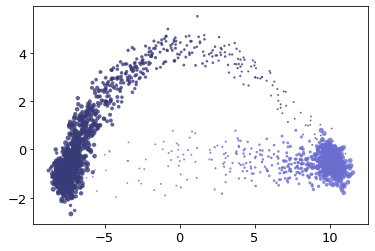

In [6]:
nCells,nGenes,T,tau,topo =  2000,100,10,[0,3,7],"aba"
name="data/simdata_aba"
meta = nCells,nGenes,T,tau,topo
simdata = simulate_occup_meas(nCells,nGenes,T,tau,topo,seed=42)
sim_export(simdata,meta,name)
vlm = vcy.VelocytoLoom(loom_filepath=name+".loom")
preprocess(vlm,sim=True,meta=meta,filter=False)
fig,ax=plt.subplots(1,1,figsize=(6,4))
plotEmbed(ax,vlm,"pcs",sim=True)

## Fig 10: The RNA velocity count processing and inference workflow, applied to data generated by stochastic simulation

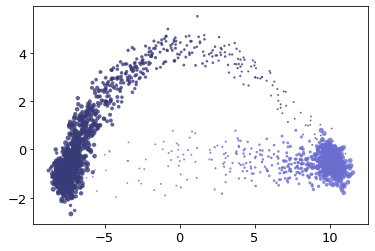

In [7]:
name="data/simdata_aba"
meta = nCells,nGenes,T,tau,topo
vlm = vcy.VelocytoLoom(loom_filepath=name+".loom")
preprocess(vlm,sim=True,meta=meta,filter=False)
fig,ax=plt.subplots(1,1,figsize=(6,4))
plotEmbed(ax,vlm,"pcs",sim=True)

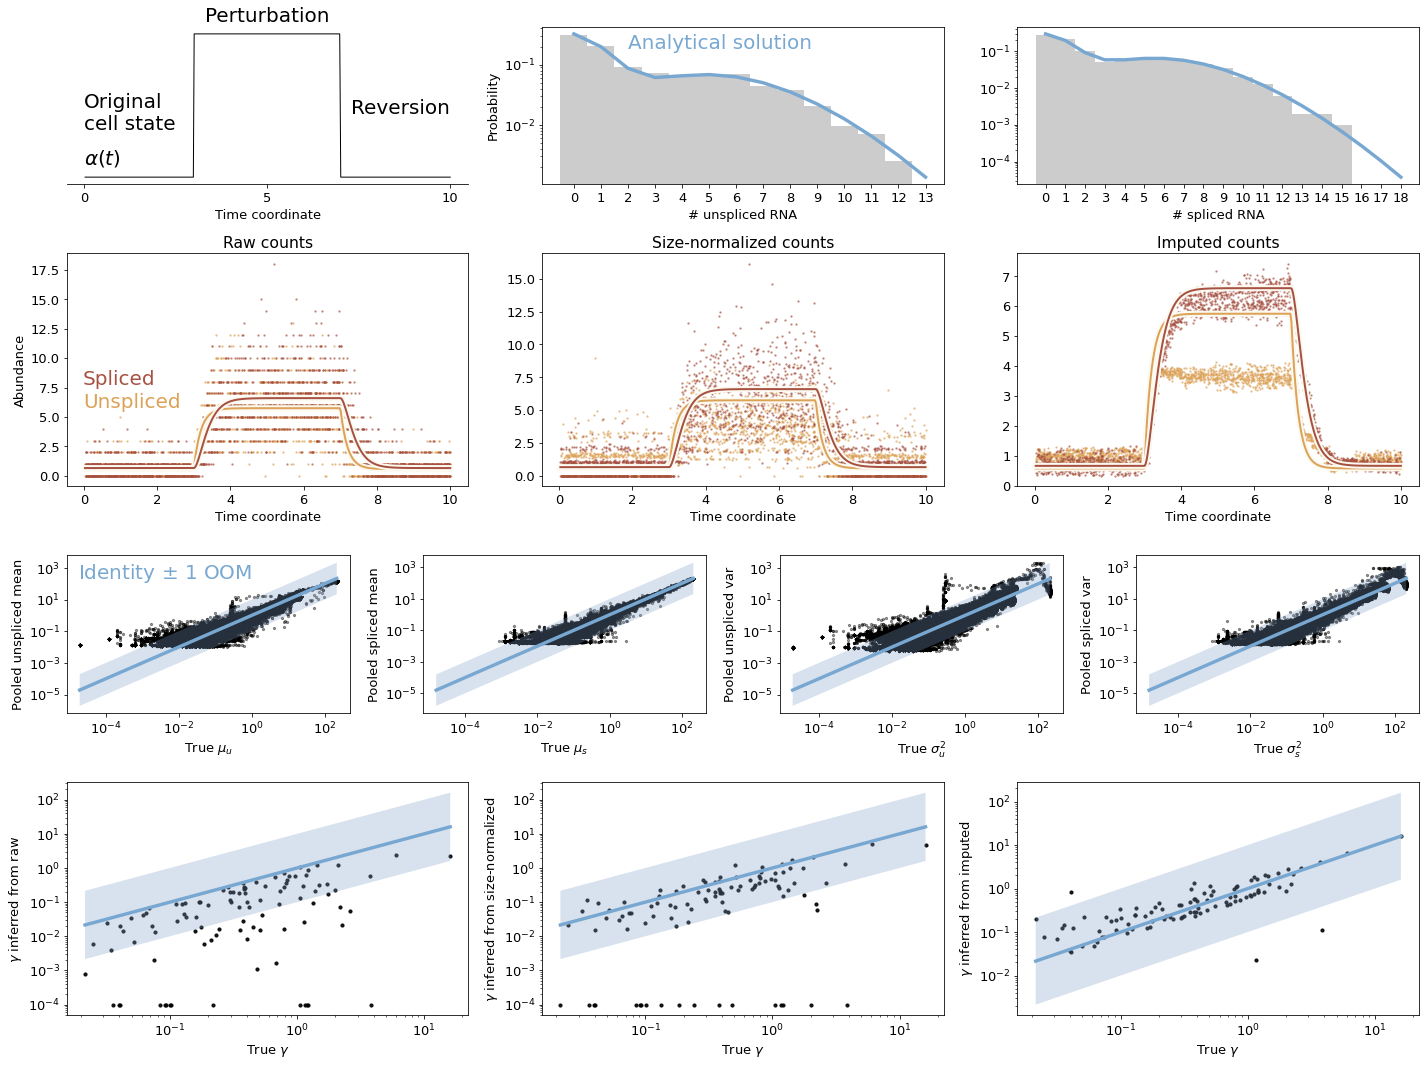

In [8]:
fig=simValidPlots(vlm,tau,meta,geneind=2)
fig.tight_layout()

In [9]:
!mkdir -p figure

In [10]:
fig.savefig('figure/fig_aba_valid.png',dpi=600)

In [11]:
t2 = time.time()
print('Notebook runtime: {:.1f} seconds.'.format(t2-t1))

Notebook runtime: 247.82 seconds.
